In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# Essential Libraries
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
import seaborn as sns
import datetime as dt
import scipy

In [2]:
from datetime import timedelta
import pywt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import ttest_rel, ttest_ind, ttest_1samp
from itertools import combinations

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import sys
sys.path.append('../src')

In [1]:
from data_helpers import load_static_feat
from result_helper import *
from stats import *

In [7]:
from matplotlib.lines import Line2D

In [3]:
from sentence_transformers import SentenceTransformer

/storage/home/tinbeh/bump_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-20 17:27:33.361683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 17:27:33.361746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 17:27:33.826469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 17:27:34.455239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binar

In [ ]:
file_loc = '/storage/data/bump/bump'

In [8]:
key = 'redcap/birthing_data.csv.gz'
df_birth = pd.read_csv(file_loc+key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

In [9]:
file_loc = '/storage/data/bump/bump/'
key = 'app_activities/surveys.csv.gz'
symptom_df = pd.read_csv(file_loc+key, compression='gzip')
#key = 'bump/app_activities/wave_7/surveys.csv.gz'
symptom_df['date'] = pd.to_datetime(symptom_df.event_date).dt.date

/tmp/ipykernel_3266/3187519186.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  symptom_df = pd.read_csv(file_loc+key, compression='gzip')


In [10]:
sr_titles = symptom_df.title.unique()
print(sr_titles)
sever_symp = symptom_df.loc[symptom_df.title==sr_titles[-2]]

['Global survey' 'Daily survey' 'Engagement survey' 'Baseline survey'
 'COVID-19 Baseline survey' 'Pilot survey' 'Maternal Social Support Index'
 'Healthcare Utilization survey' 'PUQE' 'Pain Interference survey'
 'Sleep Related Impairment survey' 'Emotional Support survey'
 'COVID Infection survey' 'Fatigue survey' 'Personality survey'
 'Severe Symptom and Complication survey' 'Perinatal PTSD']


In [11]:
df_sam = pd.read_csv(file_loc+'/bump/app_activities/quick_activities.csv.gz')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date
df_sam.label.dropna(inplace=True)
#df_sam.fillna(value={'position': 1}, inplace=True)
df_sam.stream.unique()

array(['Cognition Quick Activity', 'Energy Quick Activity',
       'Stress Quick Activity', 'Mood Quick Activity',
       'Anxiety Quick Activity'], dtype=object)

#### Sentence Transformer for extracting questions' text embeddings

In [13]:
model = SentenceTransformer('./sentence_tran_ckpt', device='cpu')


In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [16]:
rm_question = 'Are there any other symptoms not mentioned here that you have experienced in the past day?'
daily_questions = symptom_df[(symptom_df.question_text != rm_question)]
daily_questions = daily_questions[symptom_df['title'] == 'Daily survey']['question_text'].unique()#.tolist()
#daily_questions.extend(df_sam['stream'].unique().tolist())
biweekly_questions = sever_symp.question_text.unique()

/tmp/ipykernel_3266/2778191692.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  daily_questions = daily_questions[symptom_df['title'] == 'Daily survey']['question_text'].unique()#.tolist()


In [21]:
# Generate embeddings
biweekly_embeddings = model.encode(biweekly_questions)
daily_embeddings = model.encode(daily_questions)

similarity_matrix = cosine_similarity(biweekly_embeddings, daily_embeddings)

threshold = 0.5 
similar_pairs = []
for i, question_c in enumerate(biweekly_questions):
    for j, question_n in enumerate(daily_questions):
        if similarity_matrix[i][j] > threshold:
            similar_pairs.append((question_c, question_n, similarity_matrix[i][j]))

# Convert to DataFrame for readability
similar_pairs_df = pd.DataFrame(similar_pairs, columns=['Question_Severe', 'Question_Daily', 'Similarity'])
similar_pairs_df.sort_values(by='Similarity', ascending=False, inplace=True)

In [22]:
similar_pairs_df.head()

In [23]:
file_path = './sentence_tran_ckpt/similar_pairs_df_2.csv'
similar_pairs_df.to_csv(file_path, index=False)

In [24]:
# file_path = './sentence_tran_ckpt/similar_pairs_df_2.csv'
# similar_pairs_df = pd.read_csv(file_path)

In [25]:
for i in range(len(similar_pairs_df)):
    print(i)
    print(similar_pairs_df.Question_Severe.iloc[i])
    print(similar_pairs_df.Question_Daily.iloc[i])
    print('\n')

0
Have you had burning or frequent urination in the past 2 weeks?
In the past day, how would you describe the following symptom:

Trouble urinating


1
Have you experienced changes in upper abdominal pain in the past 2 weeks?
In the past day, how would you describe the following symptom:

Abdominal cramps


2
Have you experienced severe headaches in the past 2 weeks?
In the past day, have you noticed any symptoms? (e.g. nausea, fatigue, swelling, memory, mood, shortness of breath, the way you walk) 


3
Have you had burning or frequent urination in the past 2 weeks?
In the past day, have you noticed any symptoms? (e.g. fatigue, mood, anxiety, vaginal bleeding, constipation, abdominal cramps, trouble urinating) 


4
Have you had any fever, sore throat or cough in the past 2 weeks?
In the past day, have you noticed any symptoms? (e.g. nausea, fatigue, swelling, memory, mood, shortness of breath, the way you walk) 


5
Have you experienced heavy bleeding in the past 2 weeks?
In the past d

In [28]:
threshold = 5
daily_survey = symptom_df[symptom_df.title == 'Daily survey']

daily_survey = daily_survey.loc[daily_survey.question_text.str.startswith('In the past day,')]
daily_survey['answer_text'] = daily_survey['answer_text'].map({'Yes': 1, 'No': 0}).fillna(daily_survey['answer_text'])
daily_survey['answer_text'] = daily_survey['answer_text'].astype(int)
rec_id_list = sever_symp[sever_symp['answer_text']=='Yes'].record_id.unique()
daily_survey = daily_survey.loc[(daily_survey.question_text.str.contains("In the past day, have you noticed any symptoms")) | 
                                 (daily_survey.answer_text >= threshold)]
daily_survey = daily_survey[daily_survey.answer_text>0]
daily_survey = daily_survey[daily_survey.record_id.isin(rec_id_list)]
daily_survey = daily_survey.loc[:,['record_id','question_id','date','answer_text','question_text']]
print(len(daily_survey), len(sever_symp[sever_symp.answer_text=='Yes']))
print(len(daily_survey.question_id.unique()), len(sever_symp.question_text.unique()))

45673 3386
24 7


In [29]:
len(biweekly_questions), len(similar_pairs_df.Question_Severe.unique())

(7, 7)

In [30]:
all_features = []
#question_mapping 
for rec in daily_survey.record_id.unique():
    part_daily = daily_survey[daily_survey.record_id == rec].copy()
    part_daily.sort_values('date', ascending=True, inplace=True)

    part_biweekly = sever_symp[sever_symp.record_id == rec].copy()
    part_biweekly = part_biweekly[part_biweekly.answer_text == 'Yes']
    part_biweekly.sort_values('date', ascending=True, inplace=True)

    for _, biweekly_row in part_biweekly.iterrows():
        biweekly_date = biweekly_row['date']
        biweekly_question = biweekly_row['question_text']
        daily_quests = similar_pairs_df[similar_pairs_df.Question_Severe==biweekly_question].Question_Daily
        start_date = biweekly_date - pd.Timedelta(days=14)
        
        # Filter daily window for the 14-day period
        daily_window = part_daily[(part_daily['date'] > start_date) & (part_daily['date'] <= biweekly_date)]
        daily_window = daily_window[daily_window.question_text.isin(daily_quests)]
        #relevant_daily_questions = question_mapping.get(biweekly_question, [])
        #daily_window[daily_window['question_text'].isin(relevant_daily_questions)]
        
        if len(daily_window) > 0:
            daily_aggregated = daily_window.groupby('date')['answer_text'].sum().reset_index()
            daily_aggregated.columns = ['date', 'total_score']

            #highest total score
#             max_score_day = daily_aggregated.loc[daily_aggregated['total_score'].idxmax()]
            #closest day with highest total score
            max_score = daily_aggregated['total_score'].max()
            max_score_day = daily_aggregated[daily_aggregated['total_score'] == max_score]

            if len(max_score_day)>0:
                max_score_day = max_score_day.iloc[
                    (max_score_day['date'] - biweekly_date).abs().argsort().iloc[0]
                ]
            feature_record = {
                'record_id': rec,
                'biweekly_date': biweekly_date,
                'biweekly_question': biweekly_question,
                'main_day': max_score_day['date'],
                'max_total_score': max_score_day['total_score'],
                #'max_question_id': max_score_day['question_id'],
                'mean_daily_score': daily_aggregated['total_score'].mean(),
                'std_dev_daily_score': np.nan_to_num(daily_aggregated['total_score'].std())
            }
            all_features.append(feature_record)

features_df = pd.DataFrame(all_features)
features_df.head()

,record_id,biweekly_date,biweekly_question,main_day,max_total_score,mean_daily_score,std_dev_daily_score
0,sema4_281,2021-12-12,Have you had any cold or infection of any kind...,2021-12-12,1,1.000000,0.000000
1,sema4_281,2021-12-12,"Have you had any fever, sore throat or cough i...",2021-12-09,6,2.428571,2.344036
2,sema4_281,2021-12-12,Have you experienced severe headaches in the p...,2021-12-12,1,1.000000,0.000000
3,sema4_281,2021-12-26,Have you had any cold or infection of any kind...,2021-12-26,1,1.000000,0.000000
4,sema4_281,2021-12-26,"Have you had any fever, sore throat or cough i...",2021-12-22,6,1.384615,1.386750


In [31]:
features_df['biweekly_date'] = pd.to_datetime(features_df['biweekly_date'], errors='coerce')
features_df['main_day'] = pd.to_datetime(features_df['main_day'], errors='coerce')

In [32]:
features_df['date_diff'] = (features_df['biweekly_date'] - features_df['main_day']).dt.days
features_df2 = features_df.drop_duplicates(subset=['biweekly_date','record_id'])
print(len(features_df), len(features_df2), len(sever_symp[sever_symp.answer_text=='Yes'].drop_duplicates(subset=['record_id','date'])))
stats = {
    'min': features_df2['date_diff'].min(),
    'max': features_df2['date_diff'].max(),
    'mean': features_df2['date_diff'].mean(),
    'median': features_df2['date_diff'].median(),
    'std': features_df2['date_diff'].std()
}
stats

2639 1560 1932


{'min': 0,
 'max': 13,
 'mean': 1.4993589743589744,
 'median': 0.0,
 'std': 2.8803373758914517}

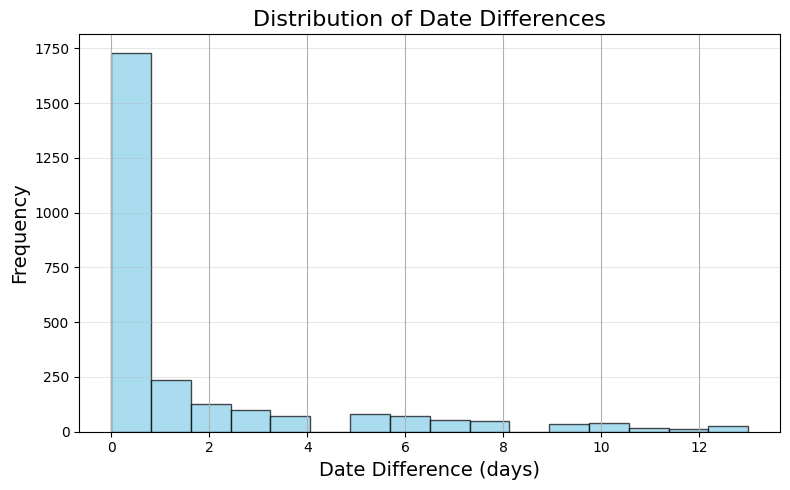

In [33]:
plt.figure(figsize=(8, 5))  # Set the figure size
features_df['date_diff'].hist(bins=16, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Distribution of Date Differences', fontsize=16)
plt.xlabel('Date Difference (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

Interpretation:

High Mean + Low Std Dev: Strong, consistent symptom association over the window.
High Mean + High Std Dev: A few high-intensity days dominate the score.
Low Mean + Low Std Dev: Weak and steady symptom association.
Low Mean + High Std Dev: Isolated spikes with otherwise low association.

In [35]:
features_df.head()

,record_id,biweekly_date,biweekly_question,main_day,max_total_score,mean_daily_score,std_dev_daily_score,date_diff
0,sema4_281,2021-12-12,Have you had any cold or infection of any kind...,2021-12-12,1,1.000000,0.000000,0
1,sema4_281,2021-12-12,"Have you had any fever, sore throat or cough i...",2021-12-09,6,2.428571,2.344036,3
2,sema4_281,2021-12-12,Have you experienced severe headaches in the p...,2021-12-12,1,1.000000,0.000000,0
3,sema4_281,2021-12-26,Have you had any cold or infection of any kind...,2021-12-26,1,1.000000,0.000000,0
4,sema4_281,2021-12-26,"Have you had any fever, sore throat or cough i...",2021-12-22,6,1.384615,1.386750,4


In [36]:
features_df.biweekly_question.unique()

array(['Have you had any cold or infection of any kind in the past 2 weeks? ',
       'Have you had any fever, sore throat or cough in the past 2 weeks?',
       'Have you experienced severe headaches in the past 2 weeks?',
       'Have you experienced heavy bleeding in the past 2 weeks?',
       'Have you experienced changes in vision in the past 2 weeks?',
       'Have you had burning or frequent urination in the past 2 weeks?'],
      dtype=object)

In [37]:
question_mapping = {
    'Have you had any cold or infection of any kind in the past 2 weeks? ': 'cold_infection',
    'Have you had any fever, sore throat or cough in the past 2 weeks?': 'fever_cough',
    'Have you experienced severe headaches in the past 2 weeks?': 'severe_headaches',
    'Have you experienced changes in vision in the past 2 weeks?': 'vision_changes',
    'Have you had burning or frequent urination in the past 2 weeks?': 'frequent_urination'
}

features_df['mapped_questions'] = features_df['biweekly_question'].map(question_mapping)
rotated_df = features_df.pivot_table(
    index=['record_id', 'main_day'],  # Index for rows
    columns='mapped_questions',       # Columns from mapped questions
    values='max_total_score',             # Values for the new columns
    aggfunc='first'                   # Use the first value if duplicates exist
).reset_index()

# Flatten the column hierarchy after pivot
rotated_df.columns.name = None
rotated_df = rotated_df.rename_axis(None, axis=1)
rotated_df.rename(columns={"main_day": "event_date"}, inplace=True)

rotated_df.head()

,record_id,event_date,cold_infection,fever_cough,frequent_urination,severe_headaches,vision_changes
0,direct_10,2022-05-26,1.0,1.0,NaN,NaN,NaN
1,direct_10,2022-09-29,1.0,1.0,NaN,NaN,NaN
2,direct_109,2022-12-29,1.0,1.0,NaN,NaN,NaN
3,direct_109,2023-03-29,1.0,1.0,NaN,NaN,NaN
4,direct_113,2022-08-24,NaN,NaN,NaN,1.0,NaN


In [38]:
sever_sym_df = rotated_df.copy()

In [39]:
df_sam = pd.read_csv(file_loc+'/bump/app_activities/quick_activities.csv.gz')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date
df_sam.label.dropna(inplace=True)

energySAM = df_sam[df_sam.stream == 'Energy Quick Activity']
cognitionSAM = df_sam[df_sam.stream == 'Cognition Quick Activity']
stressSAM = df_sam[df_sam.stream == 'Stress Quick Activity']
moodSAM = df_sam[df_sam.stream == 'Mood Quick Activity']
AnxietySAM = df_sam[df_sam.stream == 'Anxiety Quick Activity']

energySAM = energySAM.loc[energySAM.label == 'Very Low Energy']
moodSAM = moodSAM.loc[moodSAM.label.isin(['Very Negative'])]
cognitionSAM = cognitionSAM.loc[cognitionSAM.label.isin(['All Complex Tasks'])] #'Some Complex Tasks'
stressSAM = stressSAM.loc[stressSAM.label == 'Very Stressed'] #'Stressed'
AnxietySAM = AnxietySAM.loc[AnxietySAM.label == 'Very anxious'] #'Anxious'

In [40]:
df_sam[df_sam.stream == 'Cognition Quick Activity'].label.unique()

array([nan, 'Moderate Tasks', 'Some Complex Tasks', 'All Simple Tasks',
       'Some Simple Tasks', 'All Complex Tasks', 'No answer'],
      dtype=object)

In [42]:
df_sam[df_sam.stream == 'Anxiety Quick Activity'].label.unique()

array([nan, 'Calm', 'Very calm', 'Neutral', 'Anxious', 'Very anxious'],
      dtype=object)

In [45]:
print(len(energySAM), len(moodSAM), len(cognitionSAM), len(stressSAM))

4118 506 9928 703


In [46]:
# Oura Sleep
df_sleep = pd.read_csv(file_loc+'/oura/oura_sleep.csv.gz')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

def secToTime(sec):
    return dt.timedelta(seconds =sec)

df_sleep['duration_time'] = df_sleep['duration'].apply(lambda x: x if pd.isnull(x) else secToTime(x))
df_sleep['duration_min'] = df_sleep['duration'].apply(lambda x: x if pd.isnull(x) else x/60)

In [48]:
# This is the LLM based Adverse Event Report extracted using Chat-GPT
df_ae = pd.read_csv('final_covid19_positive_report.csv') 

df_ae['incident_date'] = pd.to_datetime(df_ae.incident_date).dt.date
df_ae['date'] = pd.to_datetime(df_ae.date).dt.date

df_ae['incident_date'] = df_ae.apply(
    lambda row: row['date'] - pd.Timedelta(days=7) if pd.isna(row['incident_date']) else row['incident_date'],
    axis=1
)
df_ae.head()

,user_id,record_id,redcap_event_name,date,ae_report,ae_describe,ae_notes,adverse_event_report_complete,incident_date,label
0,28,sema4_4,ci_2_arm_1,2021-04-01,1,skin irritation under watch- mild and only whe...,NaN,2,2021-03-25,Skin Irritation
1,28,sema4_4,ci_8_arm_1,2021-06-24,1,Participant fell walking down hardwood stairs ...,NaN,2,2021-06-14,Fall
2,28,sema4_4,ci_10_arm_1,2021-07-22,1,Participant had hypertensive episode on 7/16/2...,NaN,2,2021-07-16,Hypertension
3,28,sema4_4,ci_11_arm_1,2021-08-05,1,Participant went to L&D (was not admitted) for...,NaN,2,2021-07-30,Labor & Delivery
4,35,sema4_11,ci_9_arm_1,2021-07-21,1,Participant reports she has been experiencing ...,NaN,2,2021-07-21,General Health Issue


In [49]:
df_ae = df_ae.loc[df_ae.label != 'Labor & Delivery']
df_ae = df_ae.loc[df_ae.label != 'Fatigue']

In [57]:
# Test the function with the corrected code
testAE_fixed = findDaysSinceAE_fixed(df_ae)

In [58]:
# Remove rows with NA in dates
testAE = testAE_fixed.dropna(subset=['incident_date'])
testAE['daysSince'] = testAE['daysSince'] / np.timedelta64(1, 'D')
testAE = testAE.drop_duplicates(subset=['date', 'record_id', 'ae_describe'])
testAE.head()

,user_id,record_id,redcap_event_name,date,ae_report,ae_describe,ae_notes,adverse_event_report_complete,incident_date,label,daysSince
0,28,sema4_4,ci_2_arm_1,2021-04-01,1,skin irritation under watch- mild and only whe...,NaN,2,2021-03-25,Skin Irritation,-144.0
1,28,sema4_4,ci_8_arm_1,2021-06-24,1,Participant fell walking down hardwood stairs ...,NaN,2,2021-06-14,Fall,-63.0
2,28,sema4_4,ci_10_arm_1,2021-07-22,1,Participant had hypertensive episode on 7/16/2...,NaN,2,2021-07-16,Hypertension,-31.0
3,35,sema4_11,ci_9_arm_1,2021-07-21,1,Participant reports she has been experiencing ...,NaN,2,2021-07-21,General Health Issue,-63.0
4,37,sema4_13,ci_3_arm_1,2021-04-28,1,Thought it was a varicose vein and the doctor ...,Not related to study,2,2021-04-21,General Health Issue,-143.0


In [60]:
label_counts = testAE['label'].value_counts()
print(label_counts)

label
General Health Issue    132
Covid-19 Positive        35
Pain                     34
Skin Irritation          11
Fever & Body Aches       10
Nausea                    7
Fall                      6
Hypertension              4
Hyperglycemic             4
Emergency Visit           4
Shortness of Breath       1
Name: count, dtype: int64


In [65]:
testUser = 'sema4_359'
userEvents = user_events(testUser)
userEvents['date'] = pd.to_datetime(userEvents.date).dt.date
event_colors = {
        'fever_cough': '#ff4d4d',
        'severe_headaches': '#800080',
        'vision_changes': '#00ff00',
        'AE': '#0000ff',
        'SAM Stress': '#ff1493',
        'SAM Mood': '#8b0000',
        'SAM Energy': '#ffd700',
        'SAM Cognition': '#d2691e'
    }

In [67]:
event_type = ['SAM Energy', 'SAM Cognition', 'SAM Stress', 'SAM Mood', 'AE', 'cold_infection','fever_cough','severe_headaches','vision_changes','frequent_urination']
def add_event():
    all_user_sleep = pd.DataFrame()  # Initialize an empty DataFrame to collect all user sleep data
    for testUser in testAE.record_id.unique():
        userSleep = df_sleep[df_sleep['record_id'] == testUser].copy()
        userSleep = userSleep.loc[:,['record_id', 'date', 'deep','awake','hr_average','rmssd']]
        if userSleep.empty:
            continue
        userSleep = findDaysSince(userSleep)
        userSleep['daysSince'] = userSleep['daysSince'] / np.timedelta64(1, 'D')
        userSleep = userSleep.sort_values(by='daysSince')
        userEvents = user_events(testUser)
        if userEvents.empty:
            continue
        userEvents['date'] = pd.to_datetime(userEvents.date).dt.date
        events = findDaysSince(userEvents)
        events['daysSince'] = events['daysSince'] / np.timedelta64(1, 'D')
        events.drop(['date'], inplace=True, axis=1)
        events.rename(columns={"type": "event_type", "value": "event_value"}, inplace=True)
        events_pivot = events.pivot_table(index=['record_id', 'daysSince'], 
                                          columns='event_type', 
                                          values='event_value', 
                                          aggfunc='first').reset_index()
        
        userSleep = pd.merge(userSleep, events_pivot, how='left', on=['record_id', 'daysSince'])
        all_user_sleep = pd.concat([all_user_sleep, userSleep], ignore_index=True)
    return all_user_sleep
df_user_w_events = add_event()


In [68]:
fatigue = symptom_df.loc[symptom_df['question_id'] == 204]
fatigue['answer_text'] = fatigue['answer_text'].astype(int)
fatigue = fatigue.drop_duplicates(subset=['record_id','date'])
df_user_w_fatigue = pd.merge(df_user_w_events, fatigue[['record_id','date','answer_text']], on=['record_id','date'], how='left')
df_user_w_fatigue = df_user_w_fatigue.rename(columns={'answer_text': 'fatigue'})

/tmp/ipykernel_3266/3843773175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatigue['answer_text'] = fatigue['answer_text'].astype(int)


In [69]:
df_user_w_fatigue.head()

,record_id,date,deep,awake,hr_average,rmssd,daysSince,AE,SAM Cognition,SAM Energy,SAM Mood,SAM Stress,fever_cough,frequent_urination,severe_headaches,cold_infection,vision_changes,fatigue
0,sema4_4,2021-03-02,1020.0,7530.0,81.09,14.0,-167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sema4_4,2021-03-03,870.0,6570.0,76.30,17.0,-166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sema4_4,2021-03-04,690.0,7920.0,80.75,15.0,-165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sema4_4,2021-03-05,390.0,4770.0,76.59,17.0,-164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sema4_4,2021-03-06,2790.0,5760.0,74.88,22.0,-163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
event_colors = {
    'SAM Stress': '#FFD700',
    'SAM Mood': 'orange',
    'SAM Cognition': 'purple',
    'SAM Energy': 'brown',
    'cold_infection': 'cyan',
    'frequent_urination': 'chocolate',
    'fever_cough': 'green',
    'severe_headaches': 'blue',
    'vision_changes': 'grey',
    'AE': 'red',
    'Adverse Event': 'red'
}


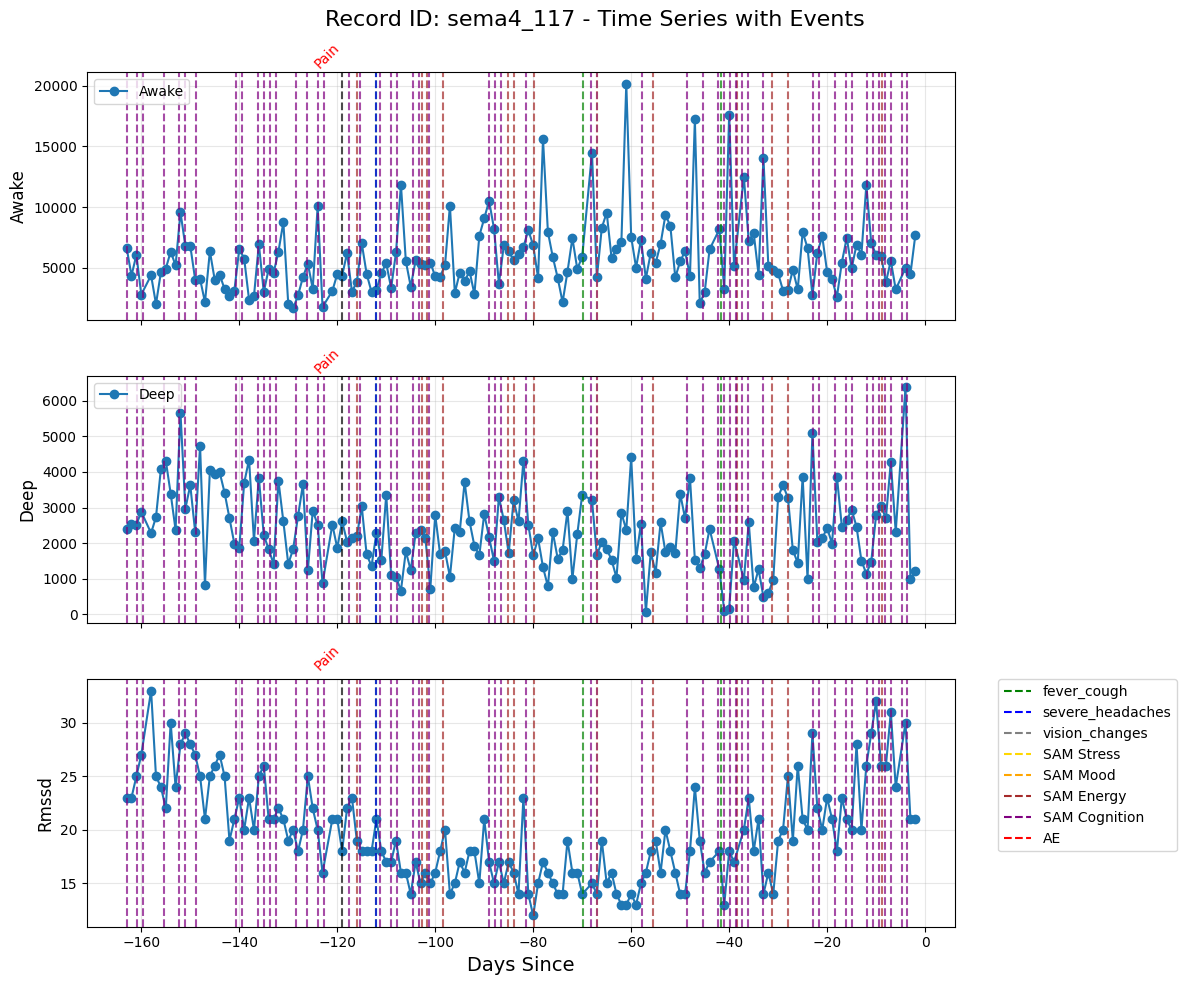

In [74]:
record_id_to_plot = random.choice(filtered_records['record_id'].unique())
df_to_plot = df_user_w_events.loc[df_user_w_events.record_id==record_id_to_plot]
df_to_plot = df_to_plot.sort_values(by='daysSince')
df_to_plot = df_to_plot[df_to_plot.daysSince<=0]
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Record ID: {record_id_to_plot} - Time Series with Events', fontsize=16)

# Plot deep, awake, and rmssd
columns_to_plot = ['awake', 'deep', 'rmssd']
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df_to_plot['daysSince'], df_to_plot[col], label=col.capitalize(), marker='o')
    axes[i].set_ylabel(col.capitalize(), fontsize=12)
    axes[i].legend(loc='upper left', fontsize=10)
    axes[i].grid(alpha=0.3)
    for idx, row in df_to_plot.iterrows():
        if pd.notna(row['AE']):
            axes[i].axvline(row['daysSince'], color='black', linestyle='--', alpha=0.7, label='AE')
            axes[i].text(row['daysSince'], df_to_plot[col].max() * 1.05, row['AE'],
                         rotation=45, fontsize=10, ha='right', va='bottom', color='red')

# Highlight events on each subplot
#event_columns = ['Mood', 'Walk', 'Remember', 'Nausea'] #'AE', 
event_columns = ['fever_cough','severe_headaches','vision_changes', 'SAM Stress', 'SAM Mood', 'SAM Energy', 'SAM Cognition']

for event in event_columns:
    event_dates = df_to_plot.loc[df_to_plot[event] > 0, 'daysSince']
    for ax in axes:
        for i, ed in enumerate(event_dates):
            # Add a small horizontal offset for overlapping events
            offset = i * 0.2
            ax.axvline(ed + offset, color=event_colors[event], linestyle='--', alpha=0.7, label=event)
# Add shared x-label
plt.xlabel('Days Since', fontsize=14)
event_columns = event_columns + ['AE']

legend_elements = [
    Line2D([0], [0], color=event_colors[event], linestyle='--', label=event)
    for event in event_columns
]

axes[-1].legend(
    handles=legend_elements, 
    loc='upper left', 
    bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

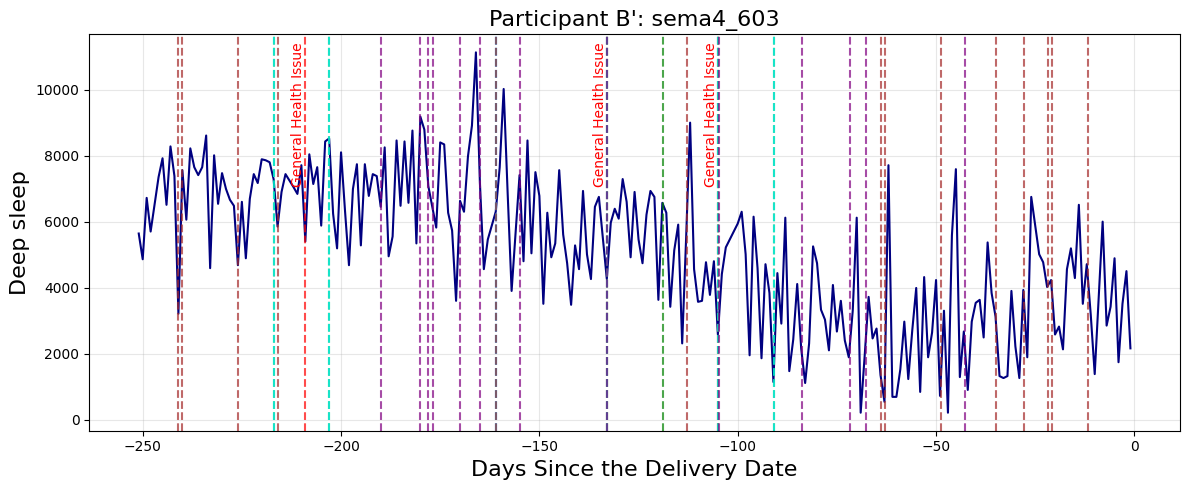

In [77]:
record_id_to_plot = random.choice(filtered_records['record_id'].unique())
df_to_plot = df_user_w_fatigue.loc[df_user_w_events.record_id==record_id_to_plot] #df_user_w_fatigue, df_user_w_events
df_to_plot = df_to_plot.sort_values(by='daysSince')
df_to_plot = df_to_plot[df_to_plot.daysSince<=0]

plt.figure(figsize=(12, 5))
plt.title(f'Participant B\': {record_id_to_plot}', fontsize=16)

# Plot deep, awake, and rmssd
columns_to_plot = ['awake', 'deep', 'rmssd', 'fatigue']
#df_to_plot['fatigue'] = impute_with_previous_mean(df_to_plot, 'fatigue')
plt.plot(df_to_plot['daysSince'], df_to_plot['deep'], label='deep'.capitalize(), color='navy') #, marker='.'
plt.ylabel('Deep Sleep'.capitalize(), fontsize=16)
#plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
ylim_top = plt.gca().get_ylim()[1]
for idx, row in df_to_plot.iterrows():
    if pd.notna(row['AE']):
        plt.axvline(row['daysSince'], color='red', linestyle='--', alpha=0.7, label='AE')
        plt.text(row['daysSince'], ylim_top * 0.98, row['AE'],  # Adjust position slightly below the top
                 rotation=90, fontsize=10, ha='right', va='top', color='red', zorder=3)

    event_columns = ['fever_cough','severe_headaches','vision_changes', 'frequent_urination','cold_infection', 'SAM Stress', 'SAM Mood', 'SAM Energy', 'SAM Cognition']

for event in event_columns:
    event_dates = df_to_plot.loc[df_to_plot[event] > 0, 'daysSince']
    for i, ed in enumerate(event_dates):
        # Add a small horizontal offset for overlapping events
        offset = i * 0.02
        plt.axvline(ed + offset, color=event_colors[event], linestyle='--', alpha=0.7, label=event)
# Add shared x-label
plt.xlabel('Days Since the Delivery Date', fontsize=16)
event_columns = event_columns + ['AE']
plt.tight_layout()
plt.show()

/tmp/ipykernel_3266/807190154.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


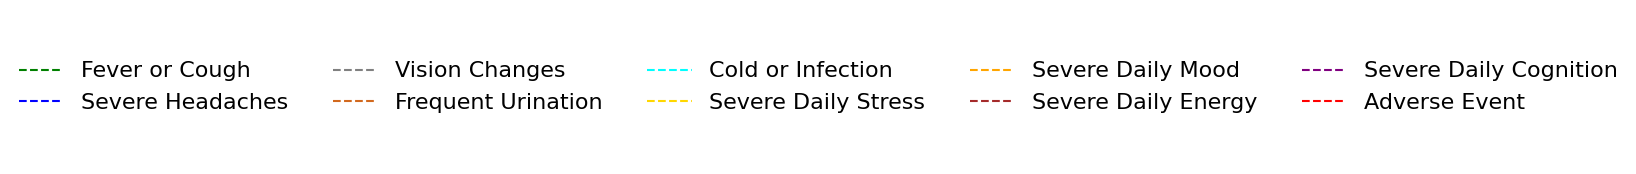

In [78]:
event_columns = ['fever_cough',
 'severe_headaches',
 'vision_changes',
 'frequent_urination',
 'cold_infection',
 'SAM Stress',
 'SAM Mood',
 'SAM Energy',
 'SAM Cognition',
 'Adverse Event']

event_legend_elements = [
    Line2D([0], [0], color=event_colors[event], linestyle='--', 
           label=(event.replace('_', ' or ').title().replace(' Or ', ' or ') if event in [
               'fever_cough', 'cold_infection']
                  else event.replace('_', ' ').title() if event in ['frequent_urination', 'severe_headaches', 'vision_changes']
                  else event.replace('SAM ', 'Severe Daily ') if event.startswith('SAM') else event))
    for event in event_columns
]

# Create a separate figure for the legend
fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('off')  # Turn off the axis

# Combine all legend elements
legend_items = event_legend_elements
plt.legend(
    handles=legend_items,
    loc='center',
    ncol=5,  # Number of columns for the legend
    frameon=False,
    prop={'size': 16}  # Font size
)

plt.tight_layout()
plt.show()

In [79]:
missing_percentage = df_user_w_fatigue.groupby('record_id')['fatigue'].apply(lambda x: x.isna().mean() * 100)

# Find the record_id with the least missing percentage
least_missing_id = missing_percentage.idxmin()
least_missing_percentage = missing_percentage.min()
sorted_missing = missing_percentage.sort_values()

# Get the second and third record_ids with the least missing percentage
second_least_missing_id = sorted_missing.index[1]
second_least_missing_percentage = sorted_missing.iloc[1]

third_least_missing_id = sorted_missing.index[2]
third_least_missing_percentage = sorted_missing.iloc[2]

least_missing_id, least_missing_percentage, second_least_missing_id, third_least_missing_id

('sema4_1099', 2.197802197802198, 'direct_186', 'sema4_589')

/tmp/ipykernel_3266/4204170755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].iloc[i] = (df[column_name].iloc[i - 1] + df[column_name].iloc[i - 2]) / 2
/tmp/ipykernel_3266/4204170755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name].iloc[i] = (df[column_name].iloc[i - 1] + df[column_name].iloc[i - 2]) / 2


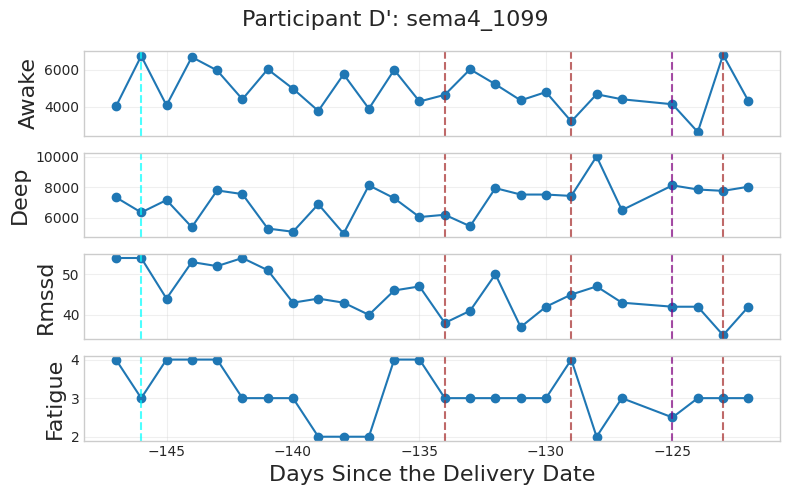

In [81]:
record_id_to_plot = random.choice(filtered_records['record_id'].unique())
df_to_plot = df_user_w_fatigue.loc[df_user_w_fatigue.record_id==record_id_to_plot]
df_to_plot = df_to_plot.sort_values(by='daysSince')
df_to_plot = df_to_plot[df_to_plot.daysSince<=0]

###Optional: Zoom into a specific section of the timeframe.
#df_to_plot = df_to_plot[df_to_plot.daysSince<=-120] 
#df_to_plot = df_to_plot[df_to_plot.daysSince>=-147] 

plt.style.use('seaborn-v0_8-whitegrid')

# Plot deep, awake, and rmssd
columns_to_plot = ['awake', 'deep', 'rmssd','fatigue']
fig, axes = plt.subplots(4, 1, figsize=(8, 5), sharex=True)
fig.suptitle(f'Participant D\': {record_id_to_plot}', fontsize=16) #Adverse and Severe symptoms Events
df_to_plot['fatigue'] = impute_with_previous_mean(df_to_plot, 'fatigue')
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df_to_plot['daysSince'], df_to_plot[col], label=col.capitalize(), marker='o')
    axes[i].set_ylabel(col.capitalize(), fontsize=16)
    axes[i].grid(alpha=0.3)

ylim_top = plt.gca().get_ylim()[1]
for idx, row in df_to_plot.iterrows():
    if pd.notna(row['AE']):
        for ax in axes:
            ax.axvline(row['daysSince'], color='red', linestyle='--', alpha=0.7, label='AE')

            ax.text(row['daysSince'], ylim_top * 0.98, row['AE'],  # Adjust position slightly below the top
                     rotation=90, fontsize=10, ha='right', va='top', color='red', zorder=3)

event_columns = ['fever_cough','severe_headaches','vision_changes', 'frequent_urination','cold_infection', 'SAM Stress', 'SAM Mood', 'SAM Energy', 'SAM Cognition']

for event in event_columns:
    event_dates = df_to_plot.loc[df_to_plot[event] > 0, 'daysSince']
    for ax in axes:
        for i, ed in enumerate(event_dates):
            offset = 0 #i * 0.02
            ax.axvline(ed + offset, color=event_colors[event], linestyle='--', alpha=0.7, label=event)
# Add shared x-label
plt.xlabel('Days Since the Delivery Date', fontsize=16)
plt.tight_layout()
plt.show()

In [82]:
len(df_user_w_events), len(df_sleep.loc[df_sleep.record_id.isin(testAE.record_id.unique())])

(26655, 26655)

In [84]:
#df_user_w_events.event_type.value_counts(normalize=True) * 100
"""
event_counts_with_nan = df_user_w_events['event_type'].value_counts(dropna=False)
event_percentage_with_nan = (event_counts_with_nan / len(df_user_w_events)) * 100
event_percentage_with_nan
"""

"\nevent_counts_with_nan = df_user_w_events['event_type'].value_counts(dropna=False)\nevent_percentage_with_nan = (event_counts_with_nan / len(df_user_w_events)) * 100\nevent_percentage_with_nan\n"

In [85]:
df_user_w_events[event_type].notna().mean().sort_values(ascending=False) * 100

SAM Cognition         9.765522
SAM Energy            3.714125
SAM Stress            0.754080
cold_infection        0.641531
fever_cough           0.619021
severe_headaches      0.592759
AE                    0.555243
SAM Mood              0.536485
frequent_urination    0.213844
vision_changes        0.146314
dtype: float64

In [86]:
df_user_w_events[event_type].describe()

,SAM Energy,SAM Cognition,SAM Stress,SAM Mood,AE,cold_infection,fever_cough,severe_headaches,vision_changes,frequent_urination
count,990.0,2603.0,201.0,143.0,148,171.0,165.0,158.0,39.0,57.0
unique,1.0,1.0,1.0,1.0,10,2.0,4.0,2.0,2.0,2.0
top,2.0,6.0,6.0,2.0,General Health Issue,1.0,1.0,1.0,1.0,1.0
freq,990.0,2603.0,201.0,143.0,83,166.0,143.0,156.0,37.0,54.0


In [87]:
len_events = 0
for eve in event_type:
    if eve != 'AE':
        len_events += len(df_user_w_events[df_user_w_events[eve]>0])
    else:
        len_events += len(df_user_w_events[df_user_w_events[eve].notna()])
print(len_events)

4675


In [96]:
ttest_results_with_effect_size_df = perform_ttest_with_effect_size(feat_name='rmssd')


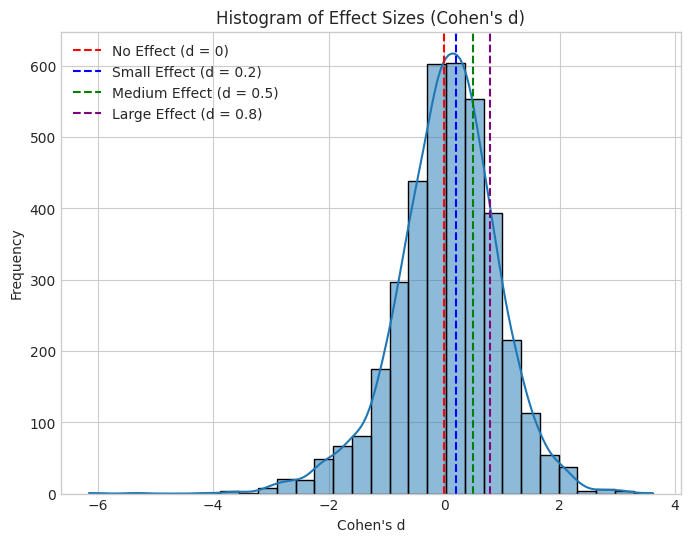

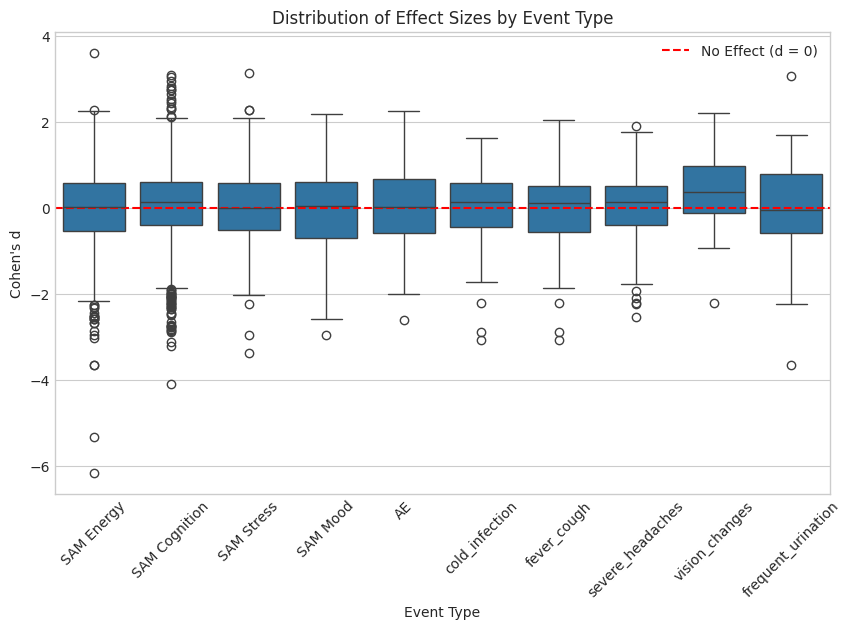

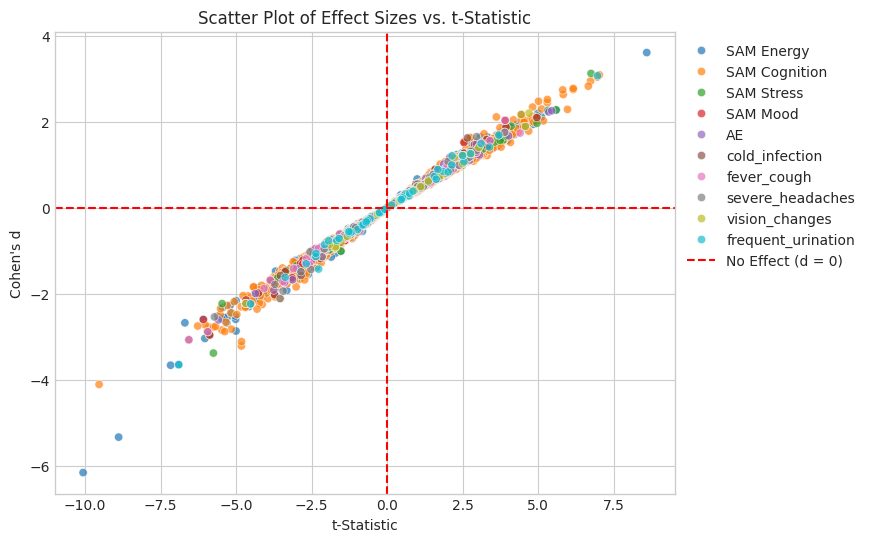

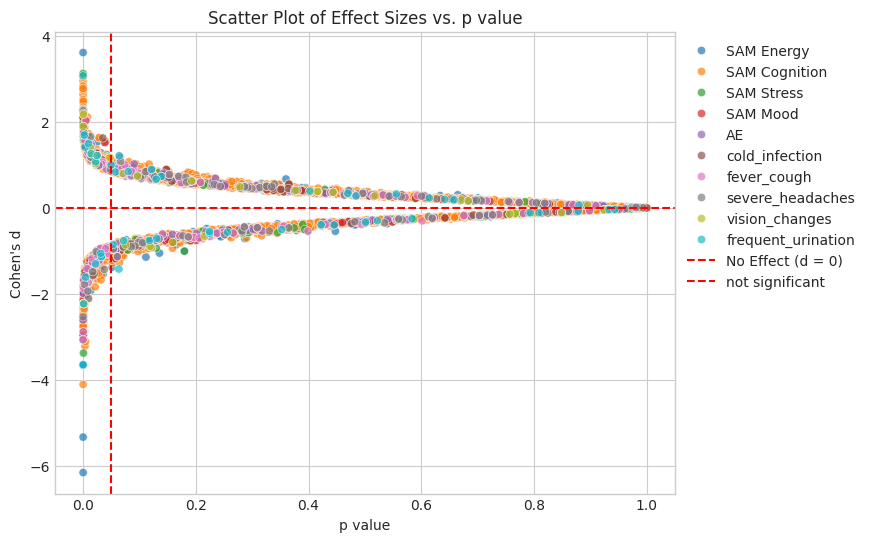

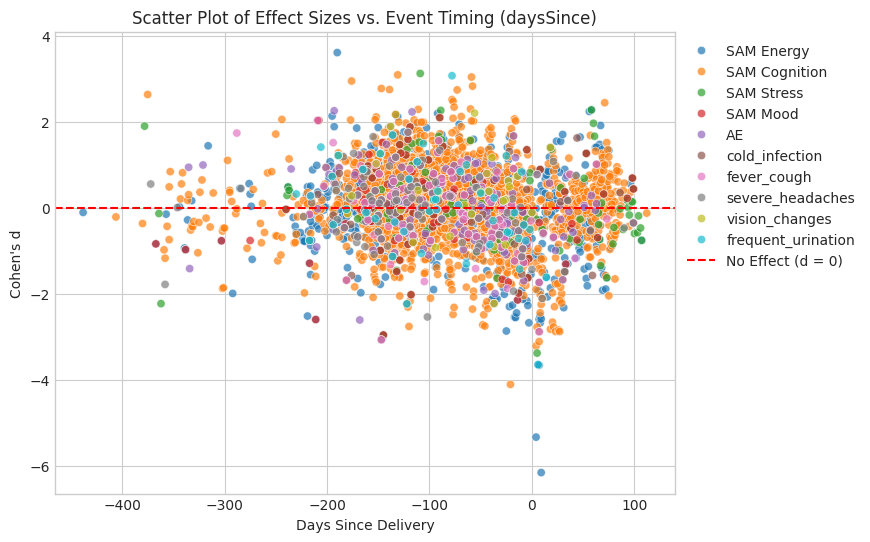

In [101]:
visualize_effect_sizes(ttest_results_with_effect_size_df)


In [98]:
ttest_results_with_effect_size_df.describe()

,daysSince,t_statistic,p_value,cohens_d
count,3748.000000,3748.000000,3.748000e+03,3748.000000
mean,-79.071505,0.145293,3.448349e-01,0.047674
std,80.568875,1.926040,3.078216e-01,0.893253
min,-438.000000,-10.065382,2.853653e-08,-6.150284
25%,-132.000000,-0.970650,5.795286e-02,-0.455804
50%,-84.000000,0.203508,2.628878e-01,0.094281
75%,-25.000000,1.343147,5.950844e-01,0.597647
max,112.000000,8.600270,1.000000e+00,3.610290


In [88]:
ttest_results_df = perform_ttest_on_events(feat_name ='rmssd')

In [89]:
ttest_results_df[ttest_results_df.p_value<0.05].head()

,record_id,daysSince,event_type,t_statistic,p_value,event_name
0,sema4_4,-143.0,SAM Energy,-3.300672,0.006029,SAM Energy
1,sema4_4,-142.0,SAM Energy,-2.266349,0.044063,SAM Energy
11,sema4_4,-86.0,SAM Energy,3.561890,0.002287,SAM Energy
12,sema4_4,-52.0,SAM Energy,2.834857,0.014783,SAM Energy
17,sema4_4,17.0,SAM Energy,2.332860,0.043321,SAM Energy


In [90]:
significant_ttest_result = ttest_results_df[ttest_results_df.p_value<0.05]
len(significant_ttest_result)

882

In [91]:
u = ttest_results_df[ttest_results_df.daysSince<=0].copy()
u.drop_duplicates(inplace=True)
event_distribution = u['record_id'].value_counts()
mean_events = event_distribution.mean()
max_events = event_distribution.max()
min_events = event_distribution.min()
median_events = event_distribution.median()

# Display results
median_events, mean_events, max_events, min_events, len(u), len(u.record_id.unique())

(9.0, 22.260563380281692, 154, 1, 3161, 142)

In [93]:
df_user_w_events.columns

Index(['record_id', 'date', 'deep', 'awake', 'hr_average', 'rmssd',
       'daysSince', 'AE', 'SAM Cognition', 'SAM Energy', 'SAM Mood',
       'SAM Stress', 'fever_cough', 'frequent_urination', 'severe_headaches',
       'cold_infection', 'vision_changes'],
      dtype='object')

In [94]:
def analyze_inter_individual_event_impact(ttest_results_df, feat_name='deep'):
    # Define the segmented 14-day windows from -270 days to 0 days
    timeframes = [(start, start + 7) for start in range(-280, 0, 7)]
    
    # Create an empty DataFrame to store the results for each event and timeframe
    event_impact_summary = []

    # Loop through each event type
    for event in ttest_results_df['event_name'].unique():
        # Filter t-test results for the current event type
        event_data = ttest_results_df[ttest_results_df['event_name'] == event]

        # Loop through each timeframe
        itrack = 0 
        for start_day, end_day in timeframes:
            # Filter results for the current timeframe
            timeframe_data = event_data[(event_data['daysSince'] >= start_day) & (event_data['daysSince'] < end_day)]

            if not timeframe_data.empty:
                # Group by individuals within the timeframe to find each person's mean t-statistic
                individual_means = timeframe_data.groupby('record_id')['t_statistic'].mean()

                # Calculate the mean and standard deviation of the individual means for the timeframe
                mean_t_stat = individual_means.mean()
                std_t_stat = individual_means.std()
                
                if len(individual_means) > 1:
                    t_test_result = ttest_1samp(individual_means, 0)
                    p_value = t_test_result.pvalue
                else:
                    p_value = float('nan')

                # Store the summary information
                event_impact_summary.append({
                    'event_type': event,
                    'timeframe': f"{start_day} to {end_day} days",
                    'mean_t_statistic': mean_t_stat,
                    'std_t_statistic': std_t_stat,
                    'p_value': p_value
                })

                # Identify pairs of individuals with high inter-individual variability
                high_variability_threshold = 2 * std_t_stat  # Define threshold as 2 standard deviations from the mean
                
                # Loop through combinations of individuals to find pairs with a large difference in t-statistics
                for (record_id_1, t_stat_1), (record_id_2, t_stat_2) in combinations(individual_means.items(), 2):
                    if abs(t_stat_1 - t_stat_2) > high_variability_threshold:
                        itrack += 1
                        if itrack < 9:
                            print(f"High variability detected between record_id: {record_id_1} and record_id: {record_id_2} "
                              f"in event: {event}, timeframe: {start_day} to {end_day} days with t_stat difference: {abs(t_stat_1 - t_stat_2)}")
                            plot_feature_around_event(df_user_w_events, record_id_1, record_id_2, event, 'rmssd', start_day, end_day)
    # Create a summary DataFrame
    event_impact_df = pd.DataFrame(event_impact_summary)

    return event_impact_df

def plot_feature_around_event(df_user_w_events, record_id_1, record_id_2, event, feat_name, start_day, end_day):
    # Define the window around the event
    plt.style.use('seaborn-v0_8-whitegrid')

    window_start = max(start_day - 16, df_user_w_events[df_user_w_events['record_id'] == record_id_1].daysSince.min())
    window_start = max(window_start, df_user_w_events[df_user_w_events['record_id'] == record_id_2].daysSince.min())
    
    window_end = min(end_day + 5, df_user_w_events[df_user_w_events['record_id'] == record_id_1].daysSince.max())
    window_end = min(window_end, df_user_w_events[df_user_w_events['record_id'] == record_id_2].daysSince.max())

    # Extract feature values for the two individuals around the event
    individual_1_data = df_user_w_events[
        (df_user_w_events['record_id'] == record_id_1) &
        (df_user_w_events['daysSince'] >= window_start) &
        (df_user_w_events['daysSince'] <= window_end)
    ]

    individual_2_data = df_user_w_events[
        (df_user_w_events['record_id'] == record_id_2) &
        (df_user_w_events['daysSince'] >= window_start) &
        (df_user_w_events['daysSince'] <= window_end)
    ]

    fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)
    axes[0].set_title(f'Feature "{feat_name}" around Event "{event}"\nComparison of Record IDs: {record_id_1} vs {record_id_2}', fontsize=16)

    # Plot data for Individual 1
    axes[0].plot(individual_1_data['daysSince'], individual_1_data[feat_name], label=f'Record ID {record_id_1}', marker='o', color='#FF8C00')
    #axes[0].set_title(f'Record ID {record_id_1} - Feature "{feat_name}"', fontsize=12)
    if event in (df_user_w_events['AE'].unique()):
        event_dates1 = individual_1_data.loc[individual_1_data['AE'] == event, 'daysSince']
        event_dates2 = individual_2_data.loc[individual_2_data['AE'] == event, 'daysSince']
        event = 'AE'
    else:
        event_dates1 = individual_1_data.loc[individual_1_data[event] > 0, 'daysSince']
        event_dates2 = individual_2_data.loc[individual_2_data[event] > 0, 'daysSince']
    for i, ed in enumerate(event_dates1):
        axes[0].axvline(ed, color=event_colors[event], linestyle='--', alpha=0.7, label='Event' if i == 0 else "")
    axes[0].set_ylabel(feat_name, fontsize=16)
    axes[0].set_xlabel('Days Since the Delivery Date', fontsize=16)
    axes[0].legend()
    axes[0].grid(True)

    # Plot data for Individual 2
    axes[1].plot(individual_2_data['daysSince'], individual_2_data[feat_name], label=f'Record ID {record_id_2}', marker='s', color='blue')
    #axes[1].set_title(f'Record ID {record_id_2} - Feature "{feat_name}"', fontsize=14)        
    for i, ed in enumerate(event_dates2):
        axes[1].axvline(ed, color=event_colors[event], linestyle='--', alpha=0.7, label='Event' if i == 0 else "")
    axes[1].set_xlabel('Days Since the Delivery Date', fontsize=16)
    axes[1].set_ylabel(feat_name, fontsize=16)
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for the overall title
    plt.show()

In [4]:
#event_impact_analysis_custom_timeframe_df = analyze_inter_individual_event_impact(ttest_results_df) #significant_ttest_result


In [140]:
df_user_w_events.head()

,record_id,date,deep,awake,hr_average,rmssd,daysSince,AE,Mood,Walk,Remember,Nausea
0,sema4_4,2021-03-02,1020.0,7530.0,81.09,14.0,-167.0,NaN,NaN,NaN,NaN,NaN
1,sema4_4,2021-03-03,870.0,6570.0,76.30,17.0,-166.0,NaN,NaN,NaN,NaN,NaN
2,sema4_4,2021-03-04,690.0,7920.0,80.75,15.0,-165.0,NaN,NaN,NaN,NaN,NaN
3,sema4_4,2021-03-05,390.0,4770.0,76.59,17.0,-164.0,NaN,NaN,NaN,NaN,NaN
4,sema4_4,2021-03-06,2790.0,5760.0,74.88,22.0,-163.0,NaN,NaN,NaN,NaN,NaN


In [141]:
# Calculate the range of t-statistics
t_stat_summary_df = calculate_t_stat_range(event_impact_analysis_custom_timeframe_df)
t_stat_summary_df

,min,max,range
event_type,,,
Covid-19 Positive,-2.343699,1.641236,3.984935
Emergency Visit,-0.167457,-0.167457,0.000000
Fall,-1.216009,2.073792,3.289802
Fever & Body Aches,-0.063998,1.163107,1.227106
General Health Issue,-2.752382,2.022711,4.775093
Hyperglycemic,-1.498572,1.538023,3.036595
Hypertension,-0.893553,1.180866,2.074419
Mood,-2.640791,1.471062,4.111854
Nausea,-1.905222,1.303056,3.208277


In [142]:
event_impact_analysis_custom_timeframe_df

,event_type,timeframe,mean_t_statistic,std_t_statistic,p_value
0,Mood,-210 to -196 days,0.649256,NaN,NaN
1,Mood,-196 to -182 days,-0.555859,NaN,NaN
2,Mood,-182 to -168 days,1.035067,NaN,NaN
3,Mood,-168 to -154 days,0.815148,NaN,NaN
4,Mood,-154 to -140 days,-0.217908,1.736154,0.888165
...,...,...,...,...,...
83,Covid-19 Positive,-42 to -28 days,1.641236,NaN,NaN
84,Covid-19 Positive,-28 to -14 days,0.495131,0.346425,0.292481
85,Hyperglycemic,-70 to -56 days,1.538023,NaN,NaN
86,Hyperglycemic,-42 to -28 days,-1.498572,NaN,NaN


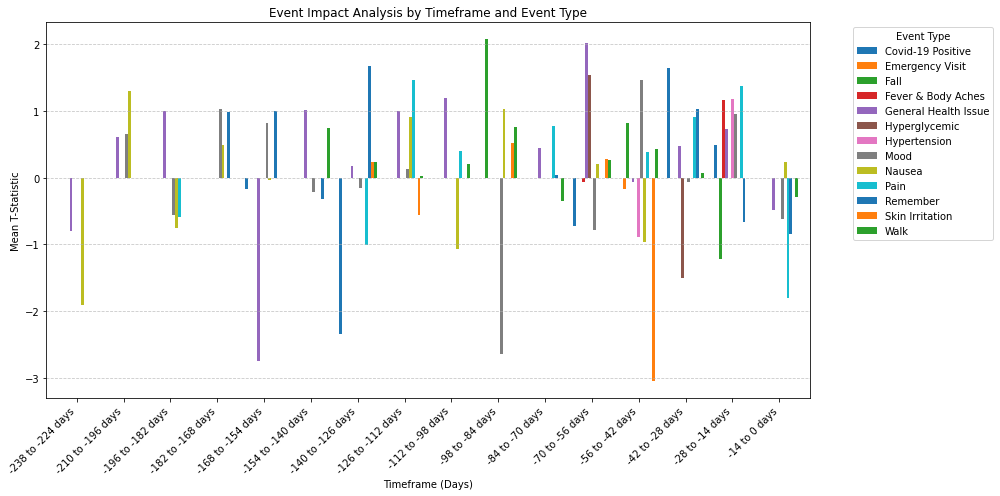

In [143]:
def plot_event_impact_summary(event_impact_df):
    pivot_table = event_impact_df.pivot(index='timeframe', columns='event_type', values='mean_t_statistic')

    pivot_table.plot(kind='bar', figsize=(14, 7), width=0.8)
    
    plt.title('Event Impact Analysis by Timeframe and Event Type')
    plt.xlabel('Timeframe (Days)')
    plt.ylabel('Mean T-Statistic')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Plotting the bar plot for the summary dataframe
event_impact_analysis_custom_timeframe_df['timeframe'] = pd.Categorical(
    event_impact_analysis_custom_timeframe_df['timeframe'], 
    categories=sorted(event_impact_analysis_custom_timeframe_df['timeframe'].unique(), key=lambda x: int(x.split()[0])),
    ordered=True
)
plot_event_impact_summary(event_impact_analysis_custom_timeframe_df)


In [47]:
def analyze_mixed_effects(event_types, df_user_w_events):
    # Loop through each event type to fit and summarize the mixed-effects model
    for event_type in event_types:
        # Build the formula for mixed effects analysis
        df_cleaned = df_user_w_events.dropna(subset=["deep", "record_id"])
        df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)
        formula = "deep ~ event_occurred * daysSince"  # Using backticks to wrap the column name safely
        
        # Fit the mixed-effects model with random intercepts for each record_id
        model = smf.mixedlm(formula, df_cleaned, groups=df_cleaned["record_id"])
        
        # Fit the model and catch any convergence issues gracefully
        try:
            result = model.fit()
            print(f"Results for Event Type: {event_type}")
            print(result.summary())
            var_components = result.cov_re.iloc[0, 0]  # Random effects variance (tau^2)
            residual_variance = result.scale            # Residual variance (sigma^2)

            # Calculate ICC
            icc = var_components / (var_components + residual_variance)

            print(f"Interclass Correlation Coefficient (ICC): {icc:.3f}")

            # Interpretation
            if icc < 0.1:
                print("Little, if any, group variability.")
            elif icc < 0.5:
                print("Moderate group variability.")
            else:
                print("Substantial group variability.")
        except Exception as e:
            print(f"Could not fit model for Event Type: {event_type}. Error: {e}")

analyze_mixed_effects(event_type, df_user_w_events)

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: SAM Stress
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2947125.8623
Min. group size:        15            Log-Likelihood:           -241491.5764
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4940.533  154.984 31.878 0.000 4636.769 5244.296
event_occurred                94.401   54.677  1.727 0.084  -12.763  201.566
daysSince                      0.940    0.138  6.817 0.000   

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: SAM Energy
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2943662.1989
Min. group size:        15            Log-Likelihood:           -241476.2030
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4988.126  155.046 32.172 0.000 4684.242 5292.010
event_occurred              -244.697   39.973 -6.122 0.000 -323.042 -166.352
daysSince                      1.099    0.144  7.628 0.000   

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: SAM Cognition
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2946766.5507
Min. group size:        15            Log-Likelihood:           -241490.2737
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4964.501  155.194 31.989 0.000 4660.326 5268.676
event_occurred              -137.314   46.369 -2.961 0.003 -228.195  -46.433
daysSince                      0.973    0.140  6.975 0.000

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: SAM Mood
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2947577.2052
Min. group size:        15            Log-Likelihood:           -241493.0229
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4943.204  154.968 31.898 0.000 4639.472 5246.935
event_occurred               107.265   75.212  1.426 0.154  -40.148  254.677
daysSince                      0.891    0.134  6.636 0.000    0

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: Fatigue
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2941367.8082
Min. group size:        15            Log-Likelihood:           -241464.8420
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4981.078  154.848 32.167 0.000 4677.581 5284.575
event_occurred              -427.449   55.817 -7.658 0.000 -536.848 -318.051
daysSince                      1.109    0.137  8.121 0.000    0.

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: Mood
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2946533.9267
Min. group size:        15            Log-Likelihood:           -241487.3399
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4954.732  154.867 31.994 0.000 4651.199 5258.265
event_occurred              -333.211  101.034 -3.298 0.001 -531.235 -135.187
daysSince                      0.941    0.133  7.088 0.000    0.681

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: Walk
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2937123.7613
Min. group size:        15            Log-Likelihood:           -241443.8852
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4976.863  154.877 32.134 0.000 4673.309 5280.417
event_occurred              -811.506   91.551 -8.864 0.000 -990.943 -632.069
daysSince                      1.027    0.132  7.765 0.000    0.768

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: Remember
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2946300.3552
Min. group size:        15            Log-Likelihood:           -241485.9426
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4955.150  154.845 32.001 0.000 4651.660 5258.641
event_occurred              -337.180  109.630 -3.076 0.002 -552.052 -122.308
daysSince                      0.931    0.132  7.033 0.000    0

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: AE
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       deep        
No. Observations:       27189         Method:                   REML        
No. Groups:             158           Scale:                    2947640.4898
Min. group size:        15            Log-Likelihood:           -241491.2921
Max. group size:        503           Converged:                Yes         
Mean group size:        172.1                                               
----------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   4947.619  154.954 31.930 0.000 4643.914 5251.324
event_occurred               -95.202  179.159 -0.531 0.595 -446.348  255.943
daysSince                      0.912    0.132  6.909 0.000    0.653  

/tmp/ipykernel_1446/4130085377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,"event_occurred"] = df_cleaned[event_type].notna().astype(int)


Results for Event Type: Nausea
                    Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       deep        
No. Observations:         27189         Method:                   REML        
No. Groups:               158           Scale:                    2939317.1775
Min. group size:          15            Log-Likelihood:           -241453.9509
Max. group size:          503           Converged:                Yes         
Mean group size:          172.1                                               
------------------------------------------------------------------------------
                            Coef.    Std.Err.   z    P>|z|   [0.025    0.975] 
------------------------------------------------------------------------------
Intercept                   4956.726  155.008 31.977 0.000  4652.916  5260.536
event_occurred             -1392.757  174.694 -7.973 0.000 -1735.150 -1050.364
daysSince                      1.011    0.